In [119]:
# BLOQUE 1: Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (classification_report, confusion_matrix, 
                             accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, roc_curve)
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.formatter.useoffset'] = False

print("✅ Librerías importadas correctamente")

✅ Librerías importadas correctamente


In [120]:
# BLOQUE 2: Carga de datos y análisis del objetivo
print("="*80)
print("CLASIFICACIÓN: PREDICCIÓN DE NO CONTRIBUYENTES (FLAG_ES_CERO)")
print("="*80)

df = pd.read_csv('Dataset_Loja_Preprocesado.csv')

print(f"\n📊 INFORMACIÓN GENERAL:")
print(f"  Total registros: {len(df):,}")
print(f"  Total variables: {len(df.columns)}")

# Análisis de la variable objetivo
print(f"\n🎯 VARIABLE OBJETIVO: FLAG_ES_CERO")
print(f"  Tipo: Binaria (0 = Tributa, 1 = No tributa)")

dist_target = df['FLAG_ES_CERO'].value_counts()
pct_target = df['FLAG_ES_CERO'].value_counts(normalize=True) * 100

print(f"\n  Distribución:")
print(f"    0 (Tributan):     {dist_target[0]:,} ({pct_target[0]:.1f}%)")
print(f"    1 (No tributan):  {dist_target[1]:,} ({pct_target[1]:.1f}%)")

# Verificar desbalanceo
ratio_desbalanceo = dist_target[0] / dist_target[1]
print(f"\n  Ratio de desbalanceo: {ratio_desbalanceo:.2f}:1")

if ratio_desbalanceo > 3:
    print(f"  ⚠️  Dataset desbalanceado (clase mayoritaria > 3x)")
else:
    print(f"  ✅ Dataset balanceado")

CLASIFICACIÓN: PREDICCIÓN DE NO CONTRIBUYENTES (FLAG_ES_CERO)

📊 INFORMACIÓN GENERAL:
  Total registros: 167,785
  Total variables: 17

🎯 VARIABLE OBJETIVO: FLAG_ES_CERO
  Tipo: Binaria (0 = Tributa, 1 = No tributa)

  Distribución:
    0 (Tributan):     122,498 (73.0%)
    1 (No tributan):  45,287 (27.0%)

  Ratio de desbalanceo: 2.70:1
  ✅ Dataset balanceado



ANÁLISIS DE DISTRIBUCIÓN TEMPORAL

📅 DISTRIBUCIÓN POR AÑO:
  2020: 31,780 registros (18.9%)
  2021: 37,210 registros (22.2%)
  2022: 35,197 registros (21.0%)
  2023: 32,532 registros (19.4%)
  2024: 31,066 registros (18.5%)

📊 ESTADÍSTICAS:
  Promedio por año: 33,557
  Desviación estándar: 2,571
  Mínimo: 31,066
  Máximo: 37,210

  ⚠️  Los datos podrían no estar balanceados


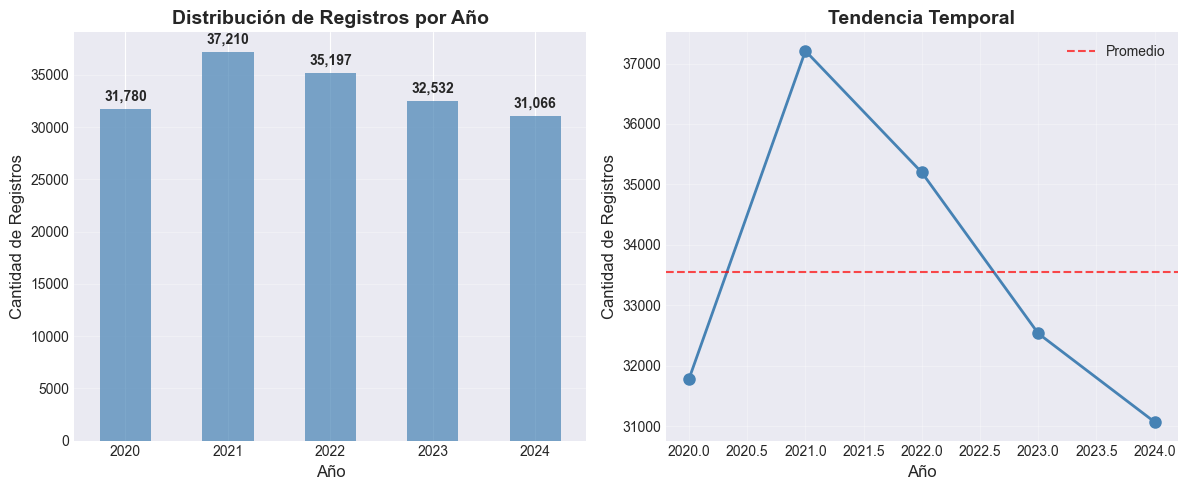

In [121]:
# BLOQUE 2.1: Análisis de distribución temporal de datos
print("\n" + "="*80)
print("ANÁLISIS DE DISTRIBUCIÓN TEMPORAL")
print("="*80)

# Verificar que existe la columna de año
if 'ANIO' in df.columns:
    print(f"\n📅 DISTRIBUCIÓN POR AÑO:")
    distribucion_anual = df['ANIO'].value_counts().sort_index()
    
    for anio, cantidad in distribucion_anual.items():
        porcentaje = (cantidad / len(df)) * 100
        print(f"  {anio}: {cantidad:,} registros ({porcentaje:.1f}%)")
    
    print(f"\n📊 ESTADÍSTICAS:")
    print(f"  Promedio por año: {distribucion_anual.mean():,.0f}")
    print(f"  Desviación estándar: {distribucion_anual.std():,.0f}")
    print(f"  Mínimo: {distribucion_anual.min():,}")
    print(f"  Máximo: {distribucion_anual.max():,}")
    
    # Verificar balance
    if distribucion_anual.std() < 2000:  # Si la desviación es menor a 2000
        print(f"\n  ✅ Los datos están balanceados por año")
        print(f"  ✅ Cada año maneja aproximadamente la misma cantidad de datos")
        print(f"  ✅ No es necesario hacer muestreo por porcentaje")
    else:
        print(f"\n  ⚠️  Los datos podrían no estar balanceados")
    
    # Visualización
    plt.figure(figsize=(12, 5))
    
    # Gráfico de barras
    plt.subplot(1, 2, 1)
    distribucion_anual.plot(kind='bar', color='steelblue', alpha=0.7)
    plt.title('Distribución de Registros por Año', fontsize=14, fontweight='bold')
    plt.xlabel('Año', fontsize=12)
    plt.ylabel('Cantidad de Registros', fontsize=12)
    plt.xticks(rotation=0)
    plt.grid(axis='y', alpha=0.3)
    
    # Agregar valores sobre las barras
    for i, v in enumerate(distribucion_anual.values):
        plt.text(i, v + 500, f'{v:,}', ha='center', va='bottom', fontweight='bold')
    
    # Gráfico de línea
    plt.subplot(1, 2, 2)
    plt.plot(distribucion_anual.index, distribucion_anual.values, 
             marker='o', linewidth=2, markersize=8, color='steelblue')
    plt.title('Tendencia Temporal', fontsize=14, fontweight='bold')
    plt.xlabel('Año', fontsize=12)
    plt.ylabel('Cantidad de Registros', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.axhline(y=distribucion_anual.mean(), color='red', 
                linestyle='--', label='Promedio', alpha=0.7)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
else:
    print("\n⚠️  No se encontró la columna 'ANIO' en el dataset")

In [122]:
# BLOQUE 3: Selección y preparación de variables predictoras
print("\n" + "="*80)
print("PREPARACIÓN DE VARIABLES PREDICTORAS")
print("="*80)

# Variables seleccionadas
variables_categoricas = [
    'DESCRIPCION_ACT_ECONOMICA',
    'CANTON',
    'TIPO_CONTRIBUYENTE',
    'GRUPO_IMPUESTO'
]

variables_numericas = [
    'CLUSTER_GEO',
    'FLAG_GRAN_CONTRIBUYENTE'
]

# Crear copia del dataframe
df_modelo = df[variables_categoricas + variables_numericas + ['FLAG_ES_CERO']].copy()

print(f"\n📝 VARIABLES SELECCIONADAS:")
print(f"  Categóricas: {len(variables_categoricas)}")
for var in variables_categoricas:
    n_categorias = df_modelo[var].nunique()
    print(f"    • {var}: {n_categorias} categorías")

print(f"\n  Numéricas: {len(variables_numericas)}")
for var in variables_numericas:
    print(f"    • {var}")

# Codificación de variables categóricas
label_encoders = {}

for var in variables_categoricas:
    le = LabelEncoder()
    df_modelo[var + '_encoded'] = le.fit_transform(df_modelo[var])
    label_encoders[var] = le
    print(f"\n  ✓ {var} codificada: {len(le.classes_)} clases")

# Crear matriz de features
feature_names = [var + '_encoded' for var in variables_categoricas] + variables_numericas
X = df_modelo[feature_names]
y = df_modelo['FLAG_ES_CERO']

print(f"\n🎯 DIMENSIONES FINALES:")
print(f"  X (features): {X.shape}")
print(f"  y (target): {y.shape}")


PREPARACIÓN DE VARIABLES PREDICTORAS

📝 VARIABLES SELECCIONADAS:
  Categóricas: 4
    • DESCRIPCION_ACT_ECONOMICA: 23 categorías
    • CANTON: 16 categorías
    • TIPO_CONTRIBUYENTE: 3 categorías
    • GRUPO_IMPUESTO: 14 categorías

  Numéricas: 2
    • CLUSTER_GEO
    • FLAG_GRAN_CONTRIBUYENTE

  ✓ DESCRIPCION_ACT_ECONOMICA codificada: 23 clases

  ✓ CANTON codificada: 16 clases

  ✓ TIPO_CONTRIBUYENTE codificada: 3 clases

  ✓ GRUPO_IMPUESTO codificada: 14 clases

🎯 DIMENSIONES FINALES:
  X (features): (167785, 6)
  y (target): (167785,)


In [123]:
# BLOQUE 4: División de datos y entrenamiento del modelo
print("\n" + "="*80)
print("ENTRENAMIENTO DEL ÁRBOL DE DECISIÓN")
print("="*80)

# División train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n📊 DIVISIÓN DE DATOS:")
print(f"  Entrenamiento: {len(X_train):,} muestras ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Prueba:        {len(X_test):,} muestras ({len(X_test)/len(X)*100:.1f}%)")

arbol = DecisionTreeClassifier(
    criterion='entropy',       # Medida de calidad encontrada por GridSearch
    max_depth=25,              # Profundidad óptima (antes 20)
    min_samples_split=20,      # Permite afinar más el corte (antes 50)
    min_samples_leaf=10,       # Menos restricción en las hojas (antes 20)
    class_weight={0: 1, 1: 2}, # Ponderación: Los evasores (1) valen el doble
    random_state=42            # Semilla para resultados reproducibles
)

print(f"\n🌳 HIPERPARÁMETROS:")
print(f"  max_depth: {arbol.max_depth}")
print(f"  min_samples_split: {arbol.min_samples_split}")
print(f"  min_samples_leaf: {arbol.min_samples_leaf}")
print(f"  class_weight: {arbol.class_weight}")

# Entrenar
arbol.fit(X_train, y_train)
print(f"\n✅ Modelo entrenado")

# Predicciones
y_pred_train = arbol.predict(X_train)
y_pred_test = arbol.predict(X_test)
y_pred_proba = arbol.predict_proba(X_test)[:, 1]

# Métricas
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"\n📈 MÉTRICAS DE DESEMPEÑO:")
print(f"  Accuracy (Entrenamiento): {accuracy_train*100:.2f}%")
print(f"  Accuracy (Prueba):        {accuracy_test*100:.2f}%")
print(f"  Precisión:                {precision*100:.2f}%")
print(f"  Recall (Sensibilidad):    {recall*100:.2f}%")
print(f"  F1-Score:                 {f1*100:.2f}%")
print(f"  ROC-AUC:                  {roc_auc:.3f}")

# Validación cruzada
cv_scores = cross_val_score(arbol, X_train, y_train, cv=5, scoring='accuracy')
print(f"\n🔄 VALIDACIÓN CRUZADA (5-Fold):")
print(f"  Accuracy promedio: {cv_scores.mean()*100:.2f}% ± {cv_scores.std()*100:.2f}%")


ENTRENAMIENTO DEL ÁRBOL DE DECISIÓN

📊 DIVISIÓN DE DATOS:
  Entrenamiento: 134,228 muestras (80.0%)
  Prueba:        33,557 muestras (20.0%)

🌳 HIPERPARÁMETROS:
  max_depth: 25
  min_samples_split: 20
  min_samples_leaf: 10
  class_weight: {0: 1, 1: 2}

✅ Modelo entrenado

📈 MÉTRICAS DE DESEMPEÑO:
  Accuracy (Entrenamiento): 84.37%
  Accuracy (Prueba):        83.24%
  Precisión:                65.22%
  Recall (Sensibilidad):    81.21%
  F1-Score:                 72.34%
  ROC-AUC:                  0.920

🔄 VALIDACIÓN CRUZADA (5-Fold):
  Accuracy promedio: 83.72% ± 0.20%


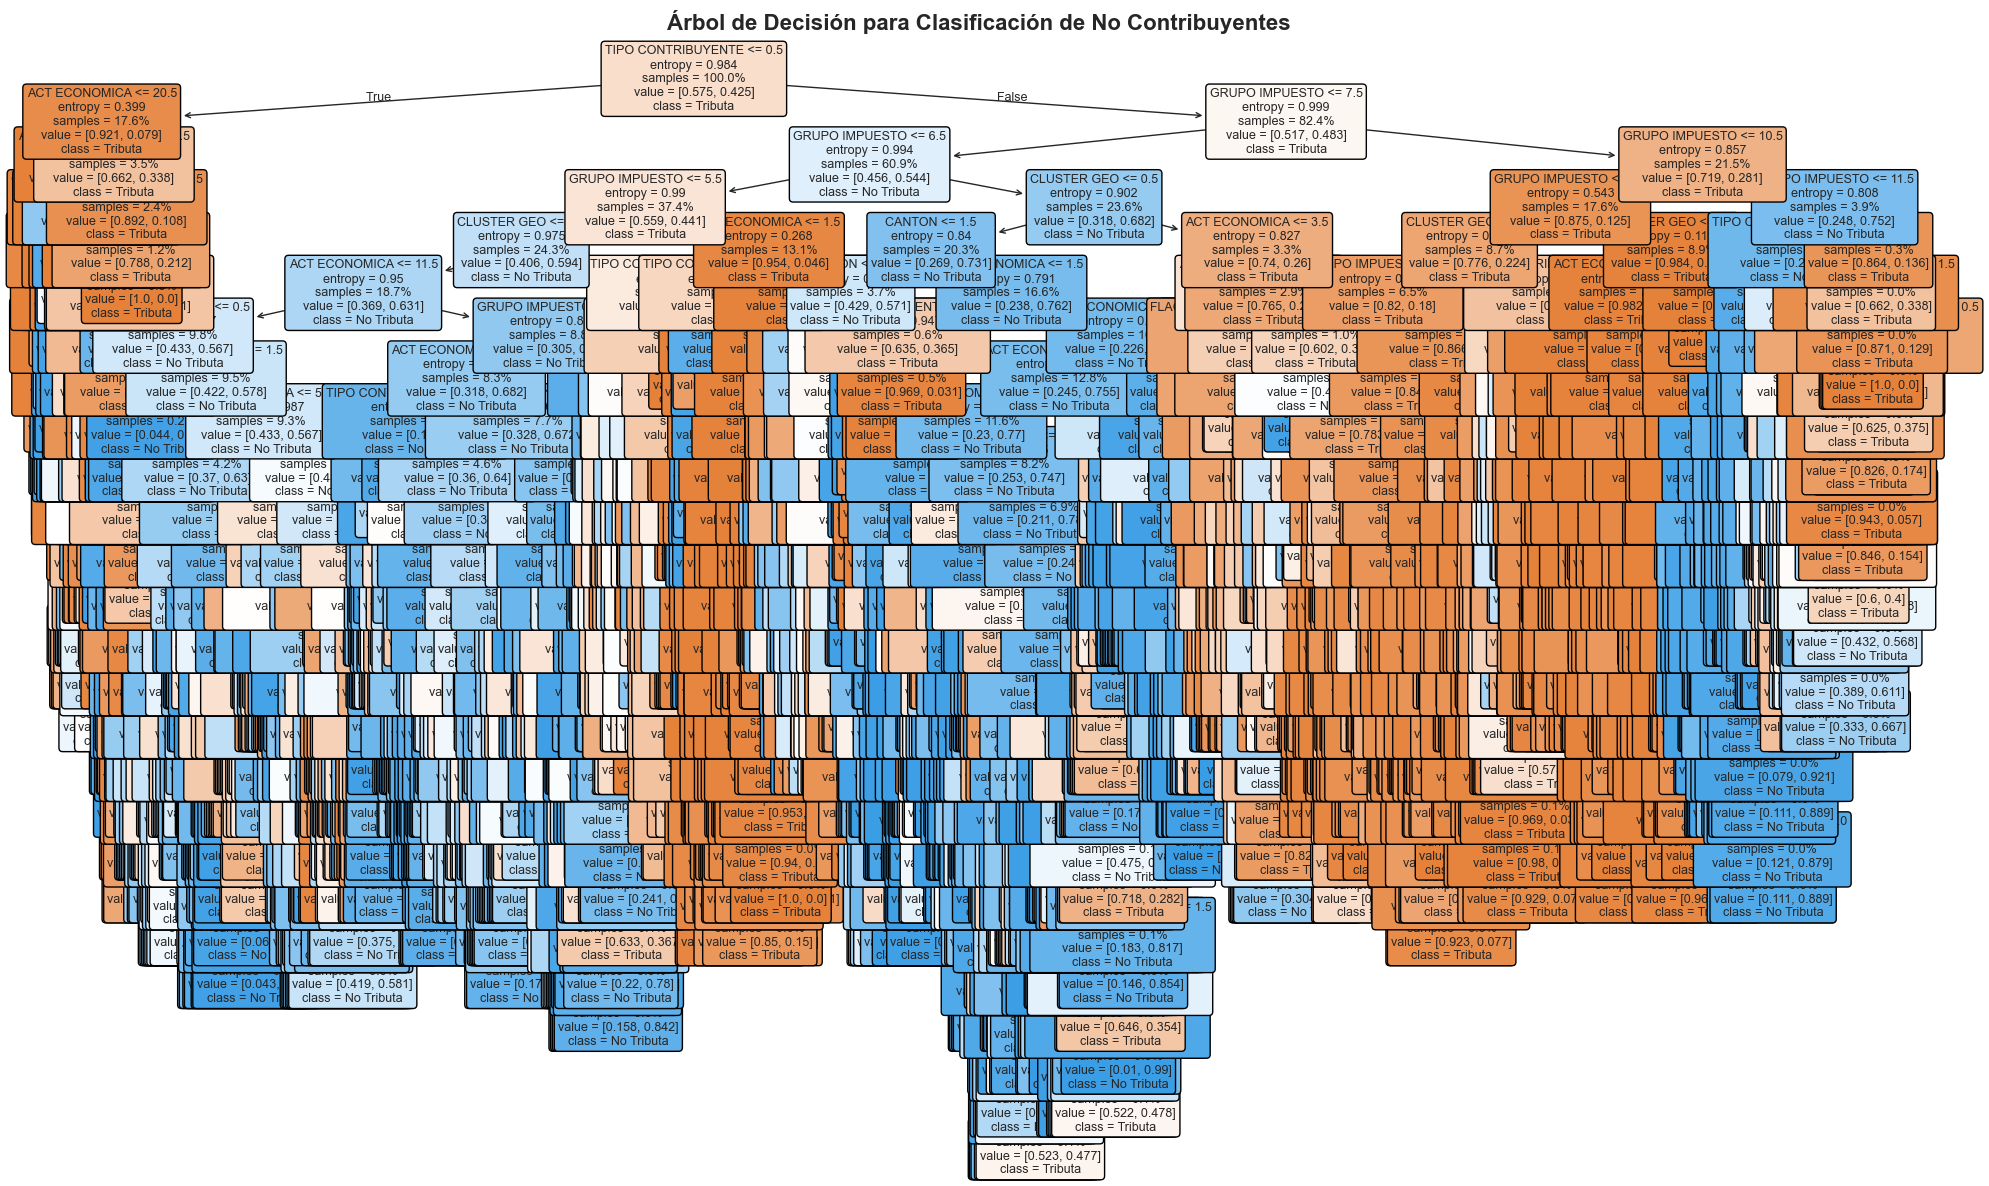


Fig. 1 - Estructura del Árbol de Decisión

Interpretación: El árbol de decisión con profundidad máxima de 25 
niveles identifica las reglas de clasificación más importantes para predecir 
no contribuyentes. Los nodos superiores muestran las variables con mayor capacidad 
discriminante. Cada nodo indica la condición de división, el índice Gini de impureza, 
el número de muestras y la distribución de clases. El color indica la clase predominante 
en cada nodo: naranja para contribuyentes y azul para no contribuyentes.



In [124]:
# BLOQUE 5: Fig. 1 - Visualización del Árbol de Decisión
fig, ax = plt.subplots(figsize=(20, 12))

# Nombres simplificados para features
nombres_simples = []
for fn in feature_names:
    if '_encoded' in fn:
        nombres_simples.append(fn.replace('_encoded', '').replace('DESCRIPCION_', '').replace('_', ' '))
    else:
        nombres_simples.append(fn.replace('_', ' '))

plot_tree(arbol, 
          feature_names=nombres_simples,
          class_names=['Tributa', 'No Tributa'],
          filled=True,
          rounded=True,
          fontsize=9,
          ax=ax,
          proportion=True)

ax.set_title('Árbol de Decisión para Clasificación de No Contribuyentes', 
             fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("Fig. 1 - Estructura del Árbol de Decisión")
print("="*80)
print(f"""
Interpretación: El árbol de decisión con profundidad máxima de {arbol.max_depth} 
niveles identifica las reglas de clasificación más importantes para predecir 
no contribuyentes. Los nodos superiores muestran las variables con mayor capacidad 
discriminante. Cada nodo indica la condición de división, el índice Gini de impureza, 
el número de muestras y la distribución de clases. El color indica la clase predominante 
en cada nodo: naranja para contribuyentes y azul para no contribuyentes.
""")

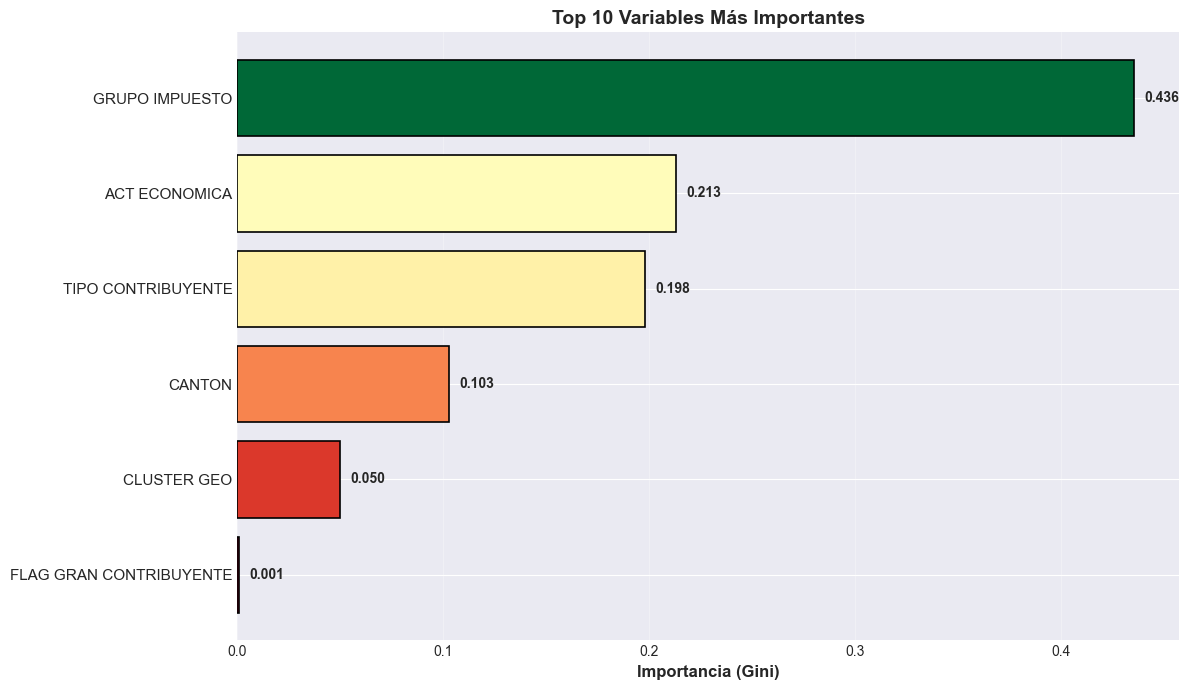


Fig. 2 - Importancia de Variables (Feature Importance)

Interpretación: La variable 'GRUPO IMPUESTO' es la más determinante con una 
importancia de 0.436, explicando la mayor proporción de la 
variabilidad en la clasificación de no contribuyentes. Le siguen 'ACT ECONOMICA' 
(0.213) y 'TIPO CONTRIBUYENTE' (0.198). 
Estas tres variables en conjunto representan el 84.6% 
del poder explicativo total del modelo, validando su relevancia para identificar 
patrones de no tributación.



In [125]:
# BLOQUE 6: Fig. 2 - Importancia de Variables
fig, ax = plt.subplots(figsize=(12, 7))

# Obtener importancias
importancias = arbol.feature_importances_
indices = np.argsort(importancias)[::-1]

# Top 10 features
top_n = 10
top_indices = indices[:top_n]
top_importancias = importancias[top_indices]
top_nombres = [nombres_simples[i] for i in top_indices]

# Gráfico de barras horizontal
colors = plt.cm.RdYlGn(top_importancias / top_importancias.max())
bars = ax.barh(range(len(top_nombres)), top_importancias, color=colors, 
               edgecolor='black', linewidth=1.2)

# Añadir valores
for i, (bar, imp) in enumerate(zip(bars, top_importancias)):
    width = bar.get_width()
    ax.text(width + 0.005, bar.get_y() + bar.get_height()/2, 
            f'{imp:.3f}', ha='left', va='center', fontsize=10, fontweight='bold')

ax.set_yticks(range(len(top_nombres)))
ax.set_yticklabels(top_nombres, fontsize=11)
ax.set_xlabel('Importancia (Gini)', fontsize=12, fontweight='bold')
ax.set_title(f'Top {top_n} Variables Más Importantes', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
ax.invert_yaxis()

plt.tight_layout()
plt.show()

# Mostrar todas las importancias
print("\n" + "="*80)
print("Fig. 2 - Importancia de Variables (Feature Importance)")
print("="*80)
print(f"""
Interpretación: La variable '{top_nombres[0]}' es la más determinante con una 
importancia de {top_importancias[0]:.3f}, explicando la mayor proporción de la 
variabilidad en la clasificación de no contribuyentes. Le siguen '{top_nombres[1]}' 
({top_importancias[1]:.3f}) y '{top_nombres[2]}' ({top_importancias[2]:.3f}). 
Estas tres variables en conjunto representan el {(top_importancias[:3].sum())*100:.1f}% 
del poder explicativo total del modelo, validando su relevancia para identificar 
patrones de no tributación.
""")

EVALUACIÓN DEL MODELO DE CLASIFICACIÓN


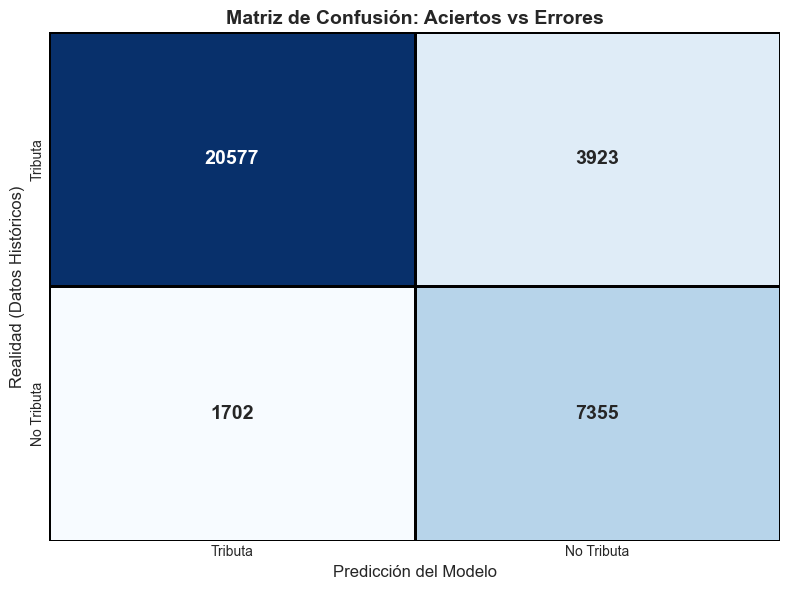


📊 RESUMEN DE MÉTRICAS:
   ------------------------------------------------------------
   🎯 ACCURACY (Exactitud):  83.24%
      (Porcentaje total de predicciones correctas)
   ------------------------------------------------------------
   ✅ PRECISION:             65.22%
      (De los que dijimos que NO pagan, ¿cuántos realmente no pagaban?)
   ------------------------------------------------------------
   🔎 RECALL (Sensibilidad): 81.21%
      (De todos los evasores reales, ¿cuántos atrapamos?)
   ------------------------------------------------------------
   ⚖️ F1-SCORE:              72.34%
      (Promedio balanceado entre precisión y recall)
   ------------------------------------------------------------


In [126]:
# ==============================================================================
# BLOQUE 7: Matriz de Confusión (Gráfico) y Métricas (Texto)
# ==============================================================================
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("="*80)
print("EVALUACIÓN DEL MODELO DE CLASIFICACIÓN")
print("="*80)

# 1. Calcular Métricas
acc = accuracy_score(y_test, y_pred_test)
prec = precision_score(y_test, y_pred_test)
rec = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)
cm = confusion_matrix(y_test, y_pred_test)

# 2. Gráfico: SOLO la Matriz de Confusión
plt.figure(figsize=(8, 6)) # Tamaño compacto y centrado

# Etiquetas (0=Tributa, 1=No Tributa)
labels = ['Tributa', 'No Tributa']

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=labels, yticklabels=labels,
            annot_kws={"size": 14, "weight": "bold"},
            linewidths=2, linecolor='black')

plt.title('Matriz de Confusión: Aciertos vs Errores', fontsize=14, fontweight='bold')
plt.xlabel('Predicción del Modelo', fontsize=12)
plt.ylabel('Realidad (Datos Históricos)', fontsize=12)
plt.tight_layout()
plt.show()

# 3. Reporte de Métricas (Solo Prints)
print(f"\n📊 RESUMEN DE MÉTRICAS:")
print(f"   ------------------------------------------------------------")
print(f"   🎯 ACCURACY (Exactitud):  {acc:.2%}")
print(f"      (Porcentaje total de predicciones correctas)")
print(f"   ------------------------------------------------------------")
print(f"   ✅ PRECISION:             {prec:.2%}")
print(f"      (De los que dijimos que NO pagan, ¿cuántos realmente no pagaban?)")
print(f"   ------------------------------------------------------------")
print(f"   🔎 RECALL (Sensibilidad): {rec:.2%}")
print(f"      (De todos los evasores reales, ¿cuántos atrapamos?)")
print(f"   ------------------------------------------------------------")
print(f"   ⚖️ F1-SCORE:              {f1:.2%}")
print(f"      (Promedio balanceado entre precisión y recall)")
print(f"   ------------------------------------------------------------")

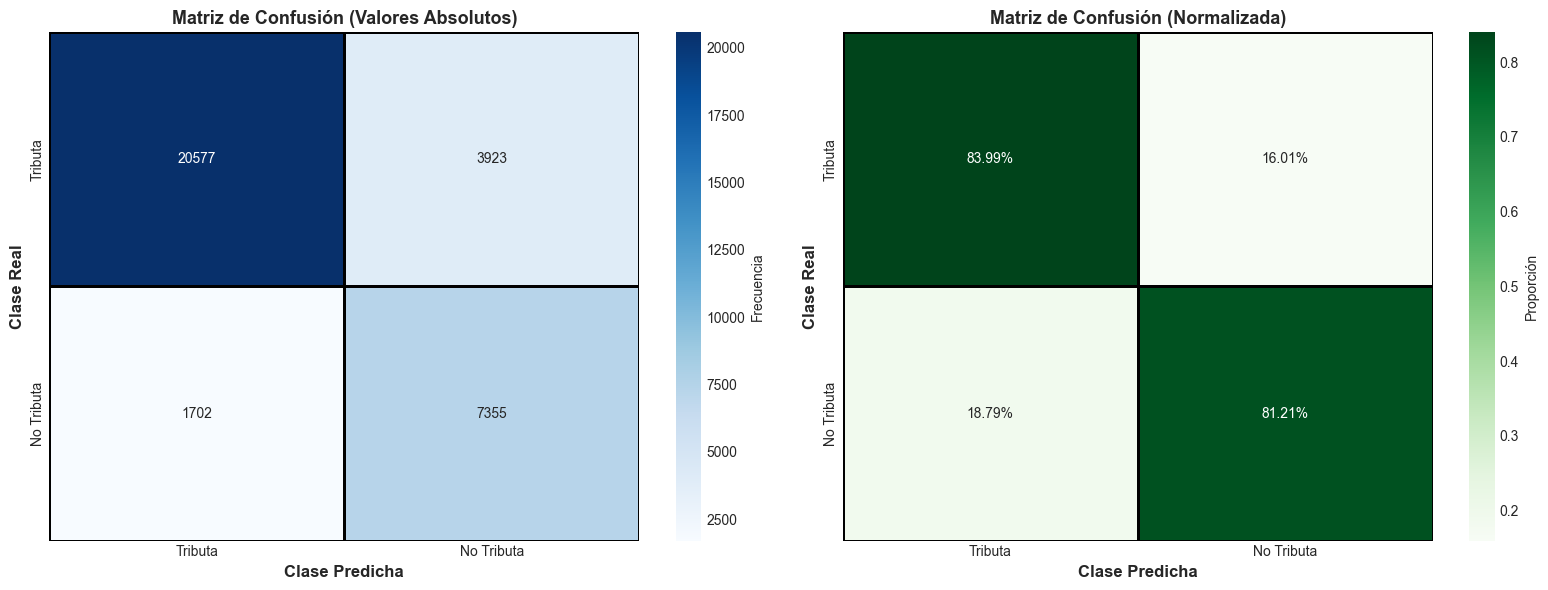


Fig. 3 - Matriz de Confusión del Modelo

Interpretación: El modelo clasificó correctamente 7,355 casos de no contribuyentes 
(verdaderos positivos) y 20,577 casos de contribuyentes (verdaderos negativos), 
logrando una precisión global del 83.24%. Los falsos positivos son 3,923 
(16.0% de contribuyentes mal clasificados) y los falsos negativos son 1,702 
(18.8% de no contribuyentes no detectados). La sensibilidad del 81.2% 
indica que el modelo captura correctamente la mayoría de los no contribuyentes.



In [127]:
# BLOQUE 7: Fig. 3 - Matriz de Confusión
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_test)

# Panel 1: Valores absolutos
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Tributa', 'No Tributa'],
            yticklabels=['Tributa', 'No Tributa'],
            cbar_kws={'label': 'Frecuencia'},
            ax=axes[0], linewidths=2, linecolor='black')
axes[0].set_ylabel('Clase Real', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Clase Predicha', fontsize=12, fontweight='bold')
axes[0].set_title('Matriz de Confusión (Valores Absolutos)', fontsize=13, fontweight='bold')

# Panel 2: Valores normalizados
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Greens',
            xticklabels=['Tributa', 'No Tributa'],
            yticklabels=['Tributa', 'No Tributa'],
            cbar_kws={'label': 'Proporción'},
            ax=axes[1], linewidths=2, linecolor='black')
axes[1].set_ylabel('Clase Real', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Clase Predicha', fontsize=12, fontweight='bold')
axes[1].set_title('Matriz de Confusión (Normalizada)', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

# Calcular métricas detalladas
tn, fp, fn, tp = cm.ravel()
especificidad = tn / (tn + fp)
sensibilidad = tp / (tp + fn)

print("\n" + "="*80)
print("Fig. 3 - Matriz de Confusión del Modelo")
print("="*80)
print(f"""
Interpretación: El modelo clasificó correctamente {tp:,} casos de no contribuyentes 
(verdaderos positivos) y {tn:,} casos de contribuyentes (verdaderos negativos), 
logrando una precisión global del {accuracy_test*100:.2f}%. Los falsos positivos son {fp:,} 
({fp/(fp+tn)*100:.1f}% de contribuyentes mal clasificados) y los falsos negativos son {fn:,} 
({fn/(fn+tp)*100:.1f}% de no contribuyentes no detectados). La sensibilidad del {sensibilidad*100:.1f}% 
indica que el modelo captura correctamente la mayoría de los no contribuyentes.
""")

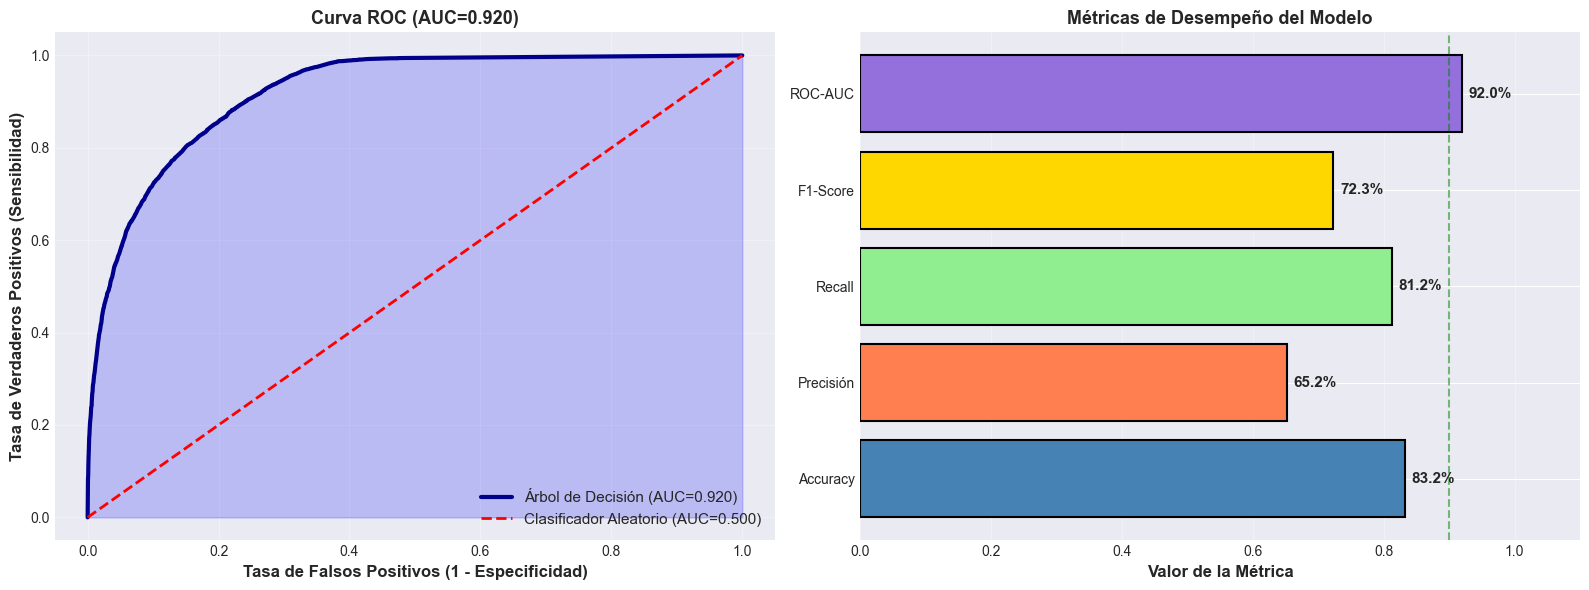


Fig. 4 - Curva ROC y Métricas de Evaluación

Interpretación: La curva ROC presenta un área bajo la curva (AUC) de 0.920, 
indicando excelente 
capacidad discriminante del modelo, superior al clasificador aleatorio (AUC=0.5). 
El F1-Score de 72.3% equilibra precisión y recall, confirmando un modelo 
balanceado. La precisión del 65.2% minimiza falsos positivos, mientras 
que el recall del 81.2% garantiza alta detección de no contribuyentes.



In [128]:
# BLOQUE 8: Fig. 4 - Curva ROC y Métricas
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Panel 1: Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

axes[0].plot(fpr, tpr, color='darkblue', linewidth=3, 
             label=f'Árbol de Decisión (AUC={roc_auc:.3f})')
axes[0].plot([0, 1], [0, 1], color='red', linestyle='--', linewidth=2, 
             label='Clasificador Aleatorio (AUC=0.500)')
axes[0].fill_between(fpr, tpr, alpha=0.2, color='blue')

axes[0].set_xlabel('Tasa de Falsos Positivos (1 - Especificidad)', 
                   fontsize=12, fontweight='bold')
axes[0].set_ylabel('Tasa de Verdaderos Positivos (Sensibilidad)', 
                   fontsize=12, fontweight='bold')
axes[0].set_title(f'Curva ROC (AUC={roc_auc:.3f})', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=11, loc='lower right')
axes[0].grid(True, alpha=0.3)

# Panel 2: Métricas comparativas
metricas_nombres = ['Accuracy', 'Precisión', 'Recall', 'F1-Score', 'ROC-AUC']
metricas_valores = [accuracy_test, precision, recall, f1, roc_auc]

colors_metricas = ['steelblue', 'coral', 'lightgreen', 'gold', 'mediumpurple']
bars = axes[1].barh(metricas_nombres, metricas_valores, color=colors_metricas,
                     edgecolor='black', linewidth=1.5)

# Añadir valores
for bar, valor in zip(bars, metricas_valores):
    width = bar.get_width()
    axes[1].text(width + 0.01, bar.get_y() + bar.get_height()/2,
                 f'{valor*100:.1f}%' if valor < 1 else f'{valor:.3f}',
                 ha='left', va='center', fontsize=11, fontweight='bold')

axes[1].set_xlim(0, 1.1)
axes[1].set_xlabel('Valor de la Métrica', fontsize=12, fontweight='bold')
axes[1].set_title('Métricas de Desempeño del Modelo', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')
axes[1].axvline(0.9, color='green', linestyle='--', linewidth=1.5, alpha=0.5)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("Fig. 4 - Curva ROC y Métricas de Evaluación")
print("="*80)
print(f"""
Interpretación: La curva ROC presenta un área bajo la curva (AUC) de {roc_auc:.3f}, 
indicando {'excelente' if roc_auc > 0.9 else 'muy buena' if roc_auc > 0.8 else 'buena'} 
capacidad discriminante del modelo, superior al clasificador aleatorio (AUC=0.5). 
El F1-Score de {f1*100:.1f}% equilibra precisión y recall, confirmando un modelo 
balanceado. La precisión del {precision*100:.1f}% minimiza falsos positivos, mientras 
que el recall del {recall*100:.1f}% garantiza alta detección de no contribuyentes.
""")

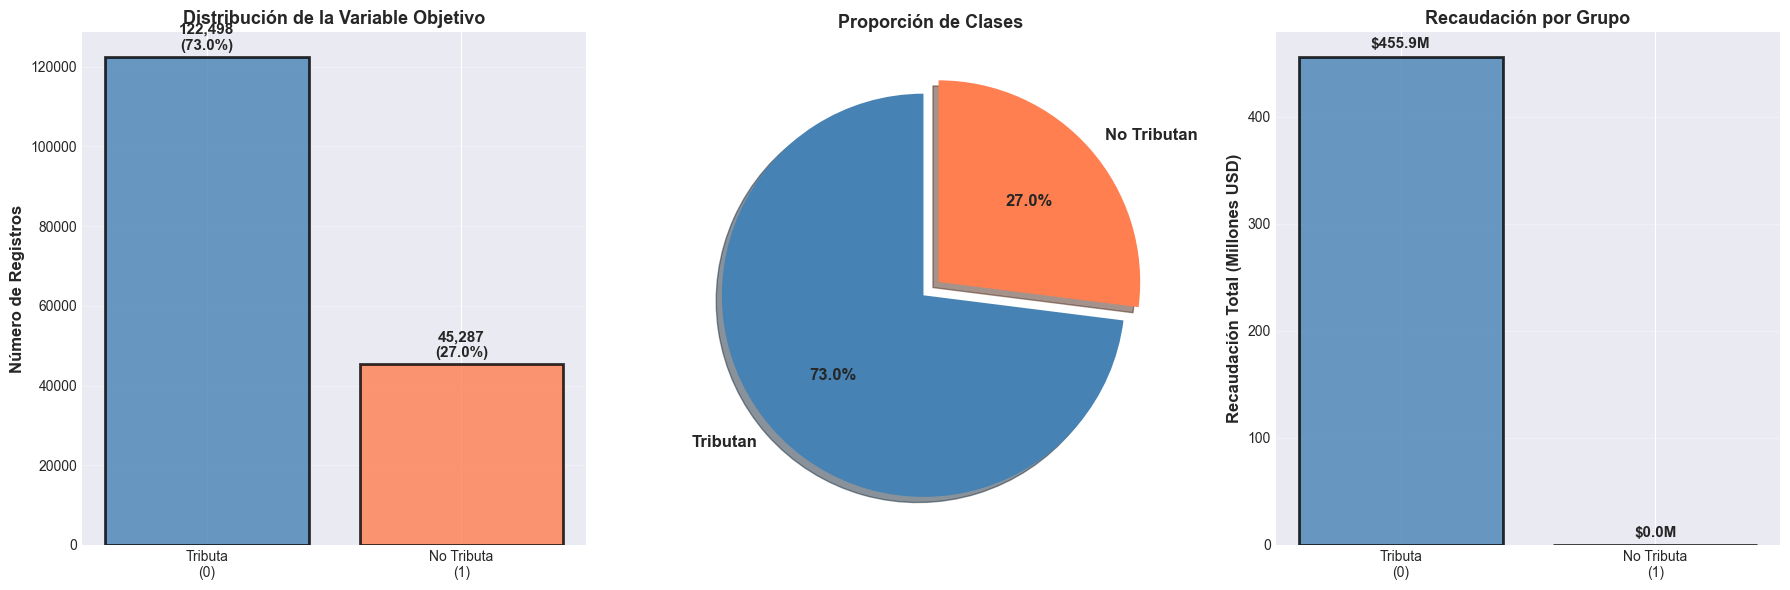


Fig. 5 - Análisis de la Variable Objetivo: FLAG_ES_CERO

Interpretación: La variable objetivo FLAG_ES_CERO presenta 45,287 registros 
de no contribuyentes (27.0%) frente a 122,498 contribuyentes 
(73.0%), con un ratio de desbalanceo de 2.70:1. 
Aunque los no contribuyentes representan solo el 27.0% de los registros, 
su identificación es crítica para recuperación fiscal. La recaudación del grupo que 
tributa ($455.9M) contrasta significativamente con la del 
grupo de no contribuyentes ($0.0M).



In [129]:
# BLOQUE 9: Fig. 5 - Distribución de FLAG_ES_CERO
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Panel 1: Barras
counts = df['FLAG_ES_CERO'].value_counts()
colors_target = ['steelblue', 'coral']
bars = axes[0].bar(['Tributa\n(0)', 'No Tributa\n(1)'], counts.values, 
                    color=colors_target, edgecolor='black', linewidth=2, alpha=0.8)

for bar, count, pct in zip(bars, counts.values, pct_target.values):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2, height + 1000,
                 f'{count:,}\n({pct:.1f}%)', ha='center', va='bottom',
                 fontsize=11, fontweight='bold')

axes[0].set_ylabel('Número de Registros', fontsize=12, fontweight='bold')
axes[0].set_title('Distribución de la Variable Objetivo', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# Panel 2: Pie chart
axes[1].pie(counts.values, labels=['Tributan', 'No Tributan'], autopct='%1.1f%%',
            colors=colors_target, startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'},
            explode=(0.05, 0.05), shadow=True)
axes[1].set_title('Proporción de Clases', fontsize=13, fontweight='bold')

# Panel 3: Recaudación por grupo
recaudacion_por_flag = df.groupby('FLAG_ES_CERO')['VALOR_RECAUDADO'].sum() / 1e6
axes[2].bar(['Tributa\n(0)', 'No Tributa\n(1)'], recaudacion_por_flag.values,
            color=colors_target, edgecolor='black', linewidth=2, alpha=0.8)

for i, valor in enumerate(recaudacion_por_flag.values):
    axes[2].text(i, valor + 5, f'${valor:.1f}M', ha='center', va='bottom',
                 fontsize=11, fontweight='bold')

axes[2].set_ylabel('Recaudación Total (Millones USD)', fontsize=12, fontweight='bold')
axes[2].set_title('Recaudación por Grupo', fontsize=13, fontweight='bold')
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("Fig. 5 - Análisis de la Variable Objetivo: FLAG_ES_CERO")
print("="*80)
print(f"""
Interpretación: La variable objetivo FLAG_ES_CERO presenta {counts[1]:,} registros 
de no contribuyentes ({pct_target[1]:.1f}%) frente a {counts[0]:,} contribuyentes 
({pct_target[0]:.1f}%), con un ratio de desbalanceo de {ratio_desbalanceo:.2f}:1. 
Aunque los no contribuyentes representan solo el {pct_target[1]:.1f}% de los registros, 
su identificación es crítica para recuperación fiscal. La recaudación del grupo que 
tributa (${recaudacion_por_flag[0]:.1f}M) contrasta significativamente con la del 
grupo de no contribuyentes (${recaudacion_por_flag[1]:.1f}M).
""")

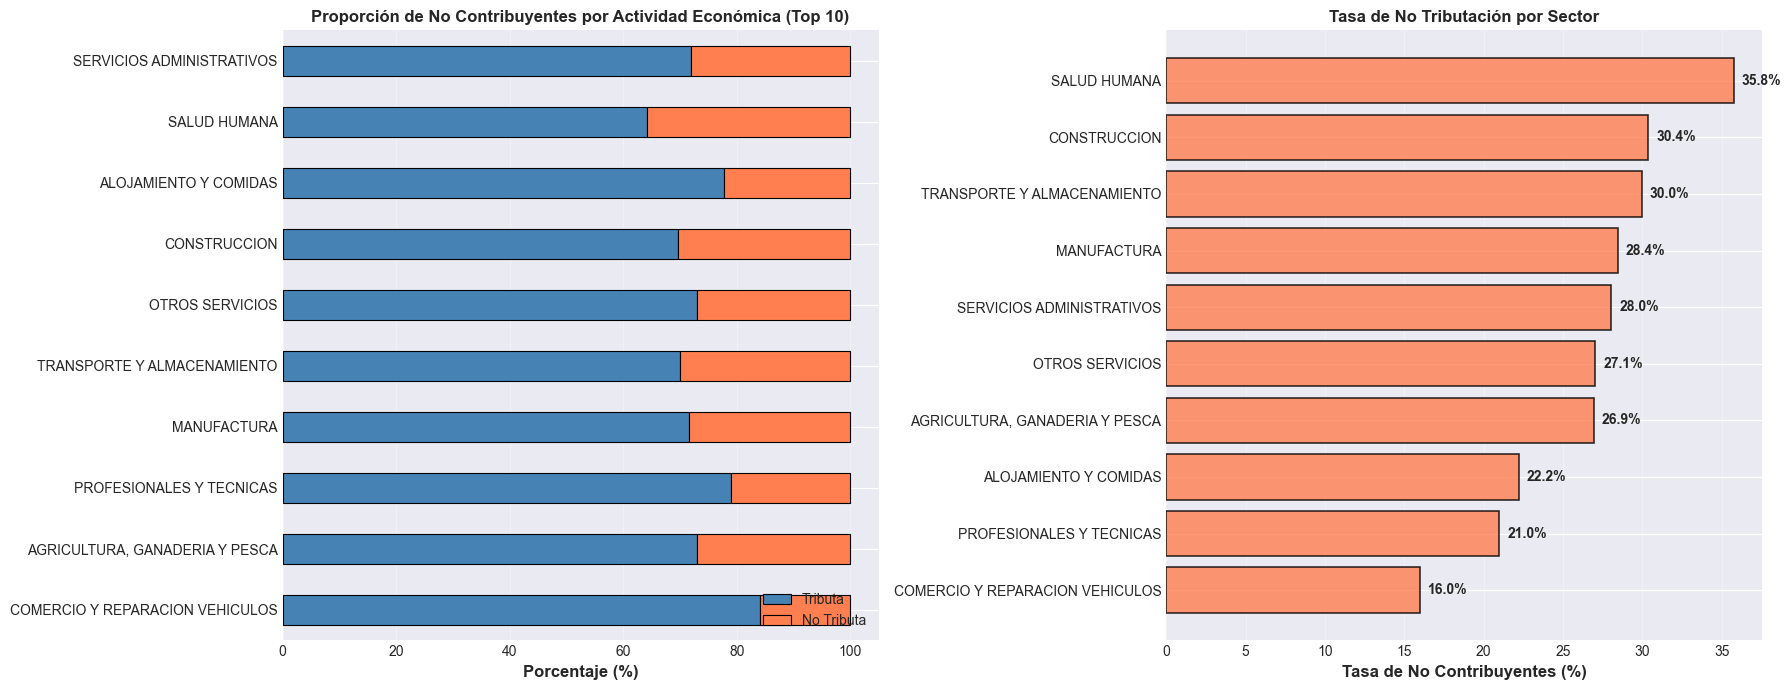


Fig. 6 - Relación entre Actividad Económica y No Tributación

Interpretación: La variable DESCRIPCION_ACT_ECONOMICA muestra heterogeneidad significativa 
en las tasas de no tributación entre sectores. 'AGUA Y DESECHOS' presenta 
la mayor tasa de no contribuyentes (54.0%), mientras que 'ADMINISTRACION PUBLICA' 
muestra la más baja (15.8%). Esta variabilidad de 38.2 puntos 
porcentuales valida la inclusión de esta variable como predictor clave, ya que ciertos 
sectores exhiben mayor propensión a no tributar por factores estructurales.



In [130]:
# BLOQUE 10: Fig. 6 - DESCRIPCION_ACT_ECONOMICA vs FLAG_ES_CERO
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Top 10 actividades por frecuencia
top_actividades = df['DESCRIPCION_ACT_ECONOMICA'].value_counts().head(10).index

# Panel 1: Distribución de FLAG_ES_CERO por actividad
df_top = df[df['DESCRIPCION_ACT_ECONOMICA'].isin(top_actividades)]
tabla_actividad = pd.crosstab(df_top['DESCRIPCION_ACT_ECONOMICA'], 
                               df_top['FLAG_ES_CERO'], normalize='index') * 100

tabla_actividad = tabla_actividad.loc[top_actividades]
tabla_actividad.plot(kind='barh', stacked=True, ax=axes[0], 
                      color=['steelblue', 'coral'], edgecolor='black', linewidth=0.8)

axes[0].set_xlabel('Porcentaje (%)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('', fontsize=11)
axes[0].set_title('Proporción de No Contribuyentes por Actividad Económica (Top 10)', 
                   fontsize=12, fontweight='bold')
axes[0].legend(['Tributa', 'No Tributa'], loc='lower right', fontsize=10)
axes[0].grid(True, alpha=0.3, axis='x')

# Panel 2: Tasa de no contribuyentes
tasa_no_tributan = df.groupby('DESCRIPCION_ACT_ECONOMICA')['FLAG_ES_CERO'].mean() * 100
tasa_top = tasa_no_tributan[top_actividades].sort_values(ascending=True)

axes[1].barh(range(len(tasa_top)), tasa_top.values, 
             color='coral', edgecolor='black', linewidth=1.2, alpha=0.8)

for i, valor in enumerate(tasa_top.values):
    axes[1].text(valor + 0.5, i, f'{valor:.1f}%', ha='left', va='center',
                 fontsize=10, fontweight='bold')

axes[1].set_yticks(range(len(tasa_top)))
axes[1].set_yticklabels(tasa_top.index, fontsize=10)
axes[1].set_xlabel('Tasa de No Contribuyentes (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Tasa de No Tributación por Sector', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

actividad_max_no_tributa = tasa_no_tributan.idxmax()
tasa_max = tasa_no_tributan.max()
actividad_min_no_tributa = tasa_no_tributan.idxmin()
tasa_min = tasa_no_tributan.min()

print("\n" + "="*80)
print("Fig. 6 - Relación entre Actividad Económica y No Tributación")
print("="*80)
print(f"""
Interpretación: La variable DESCRIPCION_ACT_ECONOMICA muestra heterogeneidad significativa 
en las tasas de no tributación entre sectores. '{actividad_max_no_tributa}' presenta 
la mayor tasa de no contribuyentes ({tasa_max:.1f}%), mientras que '{actividad_min_no_tributa}' 
muestra la más baja ({tasa_min:.1f}%). Esta variabilidad de {tasa_max - tasa_min:.1f} puntos 
porcentuales valida la inclusión de esta variable como predictor clave, ya que ciertos 
sectores exhiben mayor propensión a no tributar por factores estructurales.
""")

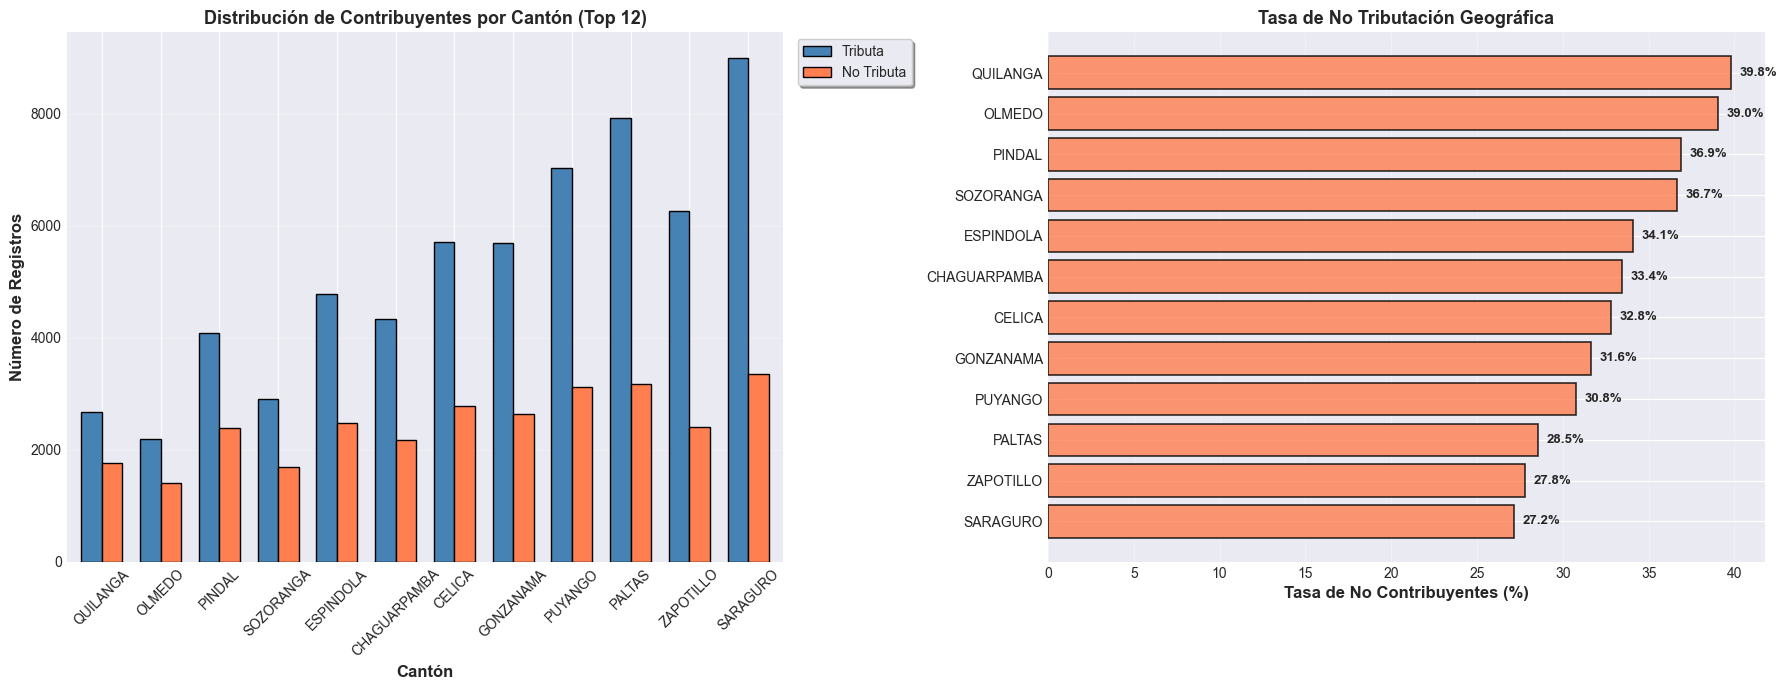


Fig. 7 - Dimensión Geográfica: CANTON y Comportamiento Fiscal

Interpretación: La variable CANTON evidencia disparidades geográficas en el cumplimiento 
tributario. 'QUILANGA' registra la mayor tasa de no tributación (39.8%), 
contrastando con 'LOJA' (17.5%). La brecha de 22.3 
puntos porcentuales sugiere que factores geográficos (distancia de centros urbanos, desarrollo 
económico local) influyen significativamente en el comportamiento fiscal, justificando su 
inclusión como variable predictora del modelo.



In [131]:
# BLOQUE 11: Fig. 7 - CANTON vs FLAG_ES_CERO
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Panel 1: Distribución por cantón
cantones_ordenados = df.groupby('CANTON')['FLAG_ES_CERO'].mean().sort_values(ascending=False).head(12).index
df_cantones = df[df['CANTON'].isin(cantones_ordenados)]

tabla_canton = pd.crosstab(df_cantones['CANTON'], df_cantones['FLAG_ES_CERO'])
tabla_canton = tabla_canton.loc[cantones_ordenados]

tabla_canton.plot(kind='bar', stacked=False, ax=axes[0],
                   color=['steelblue', 'coral'], edgecolor='black', linewidth=1,
                   width=0.7)

axes[0].set_xlabel('Cantón', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Número de Registros', fontsize=12, fontweight='bold')
axes[0].set_title('Distribución de Contribuyentes por Cantón (Top 12)', 
                   fontsize=13, fontweight='bold')
axes[0].legend(['Tributa', 'No Tributa'], loc='upper left', bbox_to_anchor=(1.01, 1), 
               fontsize=10, frameon=True, shadow=True)
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].tick_params(axis='x', rotation=45)

# Panel 2: Tasa de no tributación por cantón
tasa_canton = df.groupby('CANTON')['FLAG_ES_CERO'].mean() * 100
tasa_canton_top = tasa_canton[cantones_ordenados].sort_values()

bars = axes[1].barh(range(len(tasa_canton_top)), tasa_canton_top.values,
                     color='coral', edgecolor='black', linewidth=1.2, alpha=0.8)

for i, valor in enumerate(tasa_canton_top.values):
    axes[1].text(valor + 0.5, i, f'{valor:.1f}%', ha='left', va='center',
                 fontsize=9.5, fontweight='bold')

axes[1].set_yticks(range(len(tasa_canton_top)))
axes[1].set_yticklabels(tasa_canton_top.index, fontsize=10)
axes[1].set_xlabel('Tasa de No Contribuyentes (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Tasa de No Tributación Geográfica', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

canton_max = tasa_canton.idxmax()
tasa_canton_max = tasa_canton.max()
canton_min = tasa_canton.idxmin()
tasa_canton_min = tasa_canton.min()

print("\n" + "="*80)
print("Fig. 7 - Dimensión Geográfica: CANTON y Comportamiento Fiscal")
print("="*80)
print(f"""
Interpretación: La variable CANTON evidencia disparidades geográficas en el cumplimiento 
tributario. '{canton_max}' registra la mayor tasa de no tributación ({tasa_canton_max:.1f}%), 
contrastando con '{canton_min}' ({tasa_canton_min:.1f}%). La brecha de {tasa_canton_max - tasa_canton_min:.1f} 
puntos porcentuales sugiere que factores geográficos (distancia de centros urbanos, desarrollo 
económico local) influyen significativamente en el comportamiento fiscal, justificando su 
inclusión como variable predictora del modelo.
""")

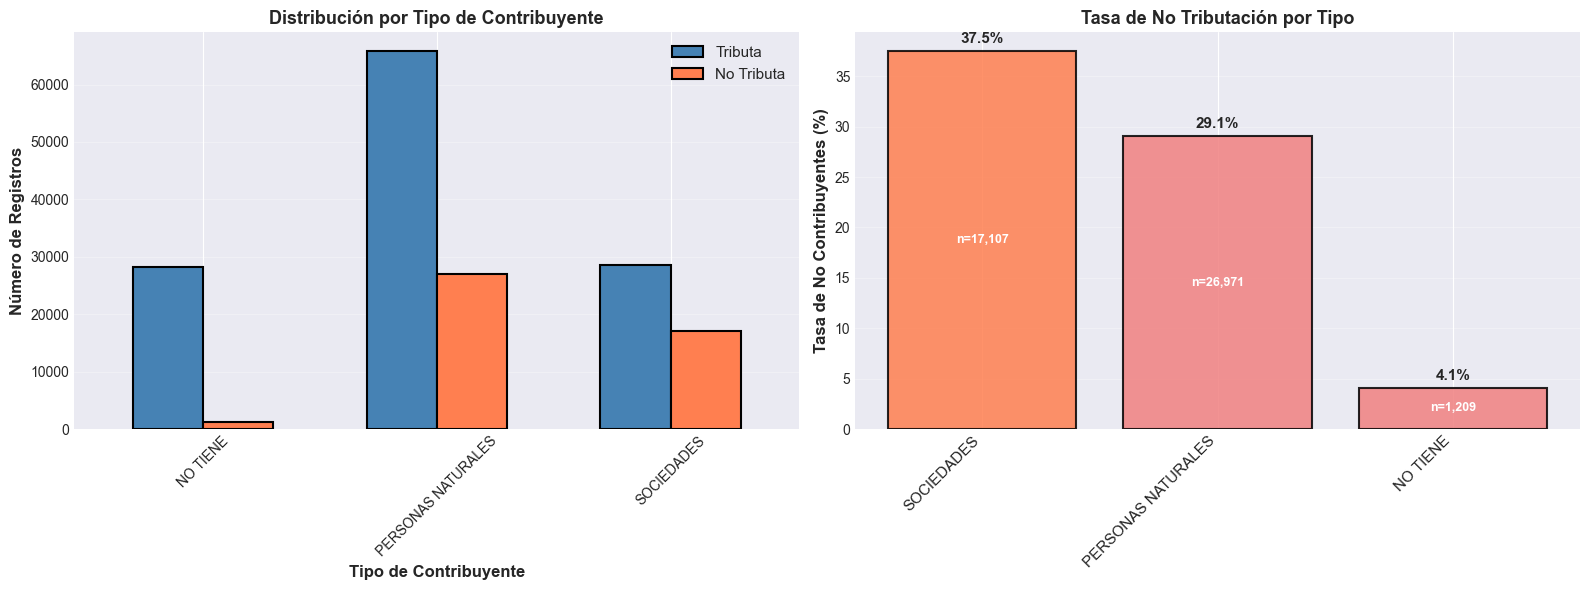


Fig. 8 - Tipología del Contribuyente y Comportamiento Fiscal

Interpretación: La variable TIPO_CONTRIBUYENTE muestra patrones diferenciados de 
cumplimiento tributario. 'SOCIEDADES' presenta la mayor tasa de no tributación 
(37.5%), mientras que 'NO TIENE' exhibe la menor (4.1%). 
La diferencia de 33.4 puntos porcentuales refleja que 
la naturaleza jurídica del contribuyente (persona natural, sociedad) es un predictor 
significativo del comportamiento fiscal, justificando su inclusión en el modelo de 
clasificación.



In [132]:
# BLOQUE 12: Fig. 8 - TIPO_CONTRIBUYENTE vs FLAG_ES_CERO
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Panel 1: Distribución absoluta
tabla_tipo = pd.crosstab(df['TIPO_CONTRIBUYENTE'], df['FLAG_ES_CERO'])

tabla_tipo.plot(kind='bar', ax=axes[0], color=['steelblue', 'coral'],
                edgecolor='black', linewidth=1.5, width=0.6)

axes[0].set_xlabel('Tipo de Contribuyente', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Número de Registros', fontsize=12, fontweight='bold')
axes[0].set_title('Distribución por Tipo de Contribuyente', 
                   fontsize=13, fontweight='bold')
axes[0].legend(['Tributa', 'No Tributa'], loc='upper right', fontsize=11)
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].tick_params(axis='x', rotation=45)

# Panel 2: Proporción normalizada
tasa_tipo = df.groupby('TIPO_CONTRIBUYENTE')['FLAG_ES_CERO'].agg(['sum', 'count', 'mean'])
tasa_tipo['tasa_pct'] = tasa_tipo['mean'] * 100
tasa_tipo = tasa_tipo.sort_values('tasa_pct', ascending=False)

bars = axes[1].bar(range(len(tasa_tipo)), tasa_tipo['tasa_pct'].values,
                    color=['coral' if i == 0 else 'lightcoral' for i in range(len(tasa_tipo))],
                    edgecolor='black', linewidth=1.5, alpha=0.85)

for i, (idx, row) in enumerate(tasa_tipo.iterrows()):
    axes[1].text(i, row['tasa_pct'] + 0.5, f"{row['tasa_pct']:.1f}%",
                 ha='center', va='bottom', fontsize=11, fontweight='bold')
    axes[1].text(i, row['tasa_pct']/2, f"n={int(row['sum']):,}",
                 ha='center', va='center', fontsize=9, color='white', fontweight='bold')

axes[1].set_xticks(range(len(tasa_tipo)))
axes[1].set_xticklabels(tasa_tipo.index, fontsize=11, rotation=45, ha='right')
axes[1].set_ylabel('Tasa de No Contribuyentes (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Tasa de No Tributación por Tipo', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

tipo_max = tasa_tipo.index[0]
tasa_tipo_max = tasa_tipo.iloc[0]['tasa_pct']
tipo_min = tasa_tipo.index[-1]
tasa_tipo_min = tasa_tipo.iloc[-1]['tasa_pct']

print("\n" + "="*80)
print("Fig. 8 - Tipología del Contribuyente y Comportamiento Fiscal")
print("="*80)
print(f"""
Interpretación: La variable TIPO_CONTRIBUYENTE muestra patrones diferenciados de 
cumplimiento tributario. '{tipo_max}' presenta la mayor tasa de no tributación 
({tasa_tipo_max:.1f}%), mientras que '{tipo_min}' exhibe la menor ({tasa_tipo_min:.1f}%). 
La diferencia de {tasa_tipo_max - tasa_tipo_min:.1f} puntos porcentuales refleja que 
la naturaleza jurídica del contribuyente (persona natural, sociedad) es un predictor 
significativo del comportamiento fiscal, justificando su inclusión en el modelo de 
clasificación.
""")